In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import math
import statsmodels.formula.api as sm
import statsmodels.tools.eval_measures as smem
from sklearn.metrics import mean_squared_error, r2_score

In [158]:
data = pd.read_csv("../00_data/data_with_calc_fields.csv", sep=";", decimal=",", index_col="datetime")
data.index = pd.to_datetime(data.index)

## Feature selection

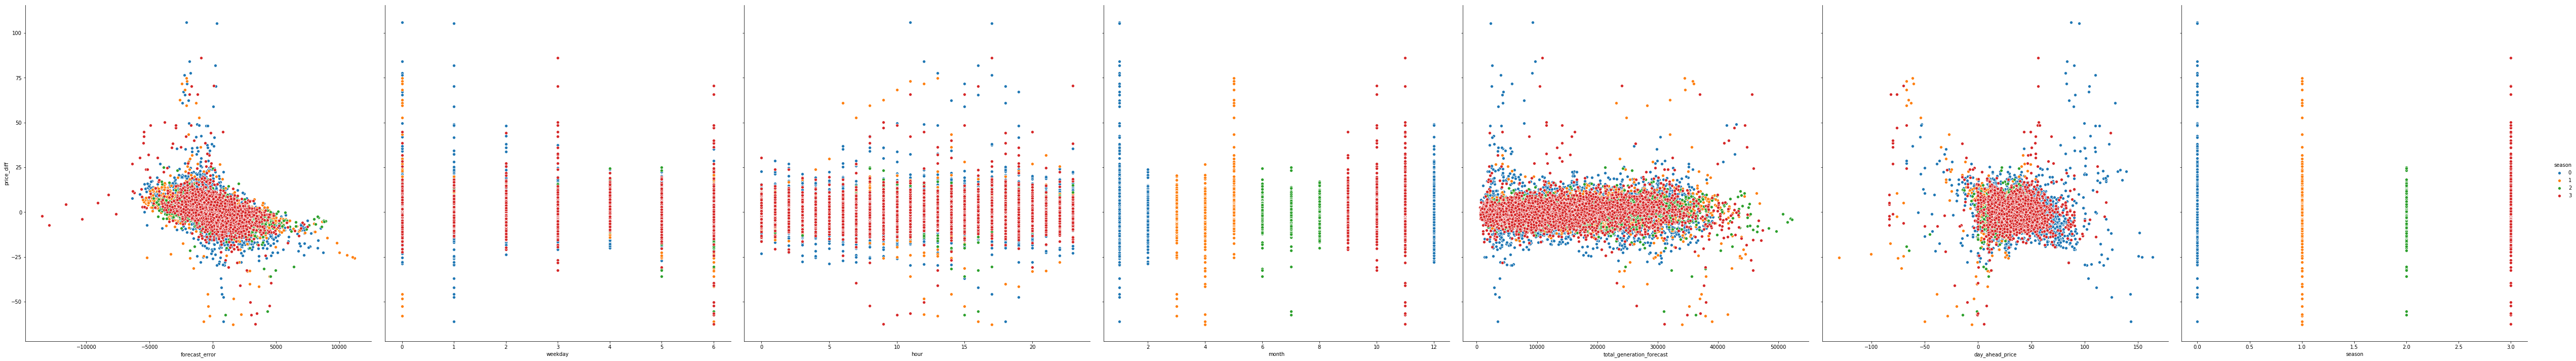

In [3]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(data, x_vars=["forecast_error", "weekday", "hour", "month", "total_generation_forecast", "day_ahead_price", "season"], y_vars=["price_diff"], height=10, hue="season")

C:\Users\Tabea\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


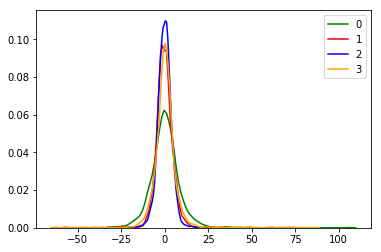

In [4]:
colors = ["g", "r", "b", "orange"]
for w in range(4):
    sns.kdeplot(data[(data.season==w)].price_diff, label=w, color=colors[w])

### => Next to forecast error, season and day_ahead_price could be useful features

In [148]:
# function to divide a data set into training and test data
def divideData(data, testSize):
    trainIndices = np.random.randint(low=0, high=len(data)-1, size=int(len(data)*testSize))
    testIndices = list(set(range(len(data))) - set(trainIndices))
    trainData = data.iloc[trainIndices,:].sort_index()
    testData = data.iloc[testIndices,:].sort_index()
    return trainData,testData

def getFormula(mode):
    if mode==0:
        formula = 'price_diff ~ forecast_error + day_ahead_price + C(season)'
    elif mode==1:
        formula = 'price_diff ~ forecast_error + day_ahead_price'
    elif mode==2:
        formula = 'price_diff ~ forecast_error + C(season)'
    elif mode==3:
        formula = 'price_diff ~ forecast_error'
    return formula

def getFormulaForDegree(degree):
    formula = 'price_diff ~ forecast_error'
    for d in range(2, degree+1):
        formula = formula+" + np.power(forecast_error, "+str(d)+")"
    return formula
    
    
# train different OLS models
def trainModel(data, mode):
    formula = getFormula(mode)
    model = sm.ols(formula, data=data).fit()
    #print(model.summary())
    return model
    
# predict price_diff with model
def predictWithModel(data, model):
    pred = model.get_prediction(data)
    summary = pred.summary_frame()
    return summary["mean"]

# function to calculate the r squared for the predicted values of a regression
def calcAdjRsquaredForPrediction(pred, y, p):
    resid = pred.sub(y, fill_value=0)
    SS_Residual = sum((resid)**2)
    SS_Total = sum((y-np.mean(y))**2)
    r2 = r2_score(y, pred)
    n = len(y)
    adjusted_r_squared = 1- (1-r2)*(n-1)/(n-(p+1))
    return adjusted_r_squared

# test various regression models
def testRegression(data):
    testSize = 0.4
    numberOfRuns = 2
    rSqrTrain = list()
    rSqrTest = list()
    mseTrain = list()
    mseTest = list()
    p = {0:4, 1:1, 2:3, 3:0}
    for m in range(4):
        print()
        print("mode:",getFormula(m))
        for i in range(numberOfRuns):
            trainData, testData = divideData(data, testSize)
            model = trainModel(trainData, m)
            rSqrTrain.append(model.rsquared_adj)
            mseTrain.append(model.mse_resid)
            pred = predictWithModel(testData, model)
            mseTest.append(smem.mse(pred,testData["price_diff"]))
            rSqrTest.append(calcAdjRsquaredForPrediction(pred, testData["price_diff"], p[m]))
        print("Mean R^2 training data for",numberOfRuns,"runs:","{:2f}".format(sum(rSqrTrain)/len(rSqrTrain)))
        print("Mean R^2 testing data for",numberOfRuns,"runs:","{:2f}".format(sum(rSqrTest)/len(rSqrTest)))
        print("Mean MSE training data for",numberOfRuns,"runs:","{:2f}".format(sum(mseTrain)/len(mseTrain)))
        print("Mean MSE testing data for",numberOfRuns,"runs:","{:2f}".format(sum(mseTest)/len(mseTest)))
        pred = model.predict(testData)

SyntaxError: invalid syntax (<ipython-input-148-d7571fbbddb1>, line 75)


mode: price_diff ~ forecast_error + day_ahead_price + C(season)
Mean R^2 training data for 2 runs: 0.214487
Mean R^2 testing data for 2 runs: 0.204722
Mean MSE training data for 2 runs: 38.616915
Mean MSE testing data for 2 runs: 35.878123


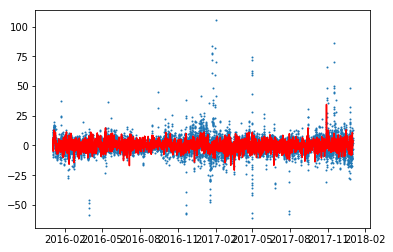


mode: price_diff ~ forecast_error + day_ahead_price
Mean R^2 training data for 2 runs: 0.217826
Mean R^2 testing data for 2 runs: 0.200337
Mean MSE training data for 2 runs: 36.266016
Mean MSE testing data for 2 runs: 37.399577


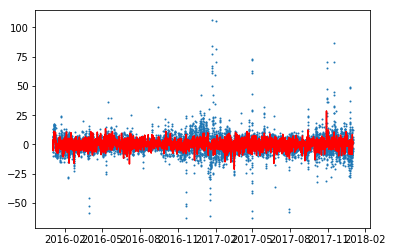


mode: price_diff ~ forecast_error + C(season)
Mean R^2 training data for 2 runs: 0.208066
Mean R^2 testing data for 2 runs: 0.202664
Mean MSE training data for 2 runs: 37.801576
Mean MSE testing data for 2 runs: 36.993312


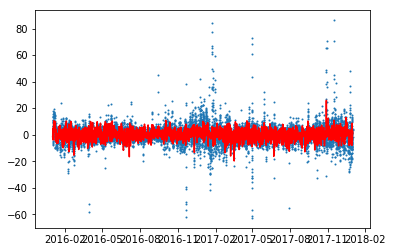


mode: price_diff ~ forecast_error
Mean R^2 training data for 2 runs: 0.206431
Mean R^2 testing data for 2 runs: 0.201913
Mean MSE training data for 2 runs: 38.015028
Mean MSE testing data for 2 runs: 36.934677


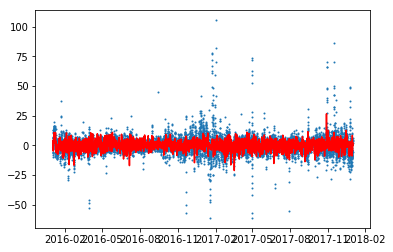

In [128]:
testRegression(data)

ValueError: x and y must be the same size

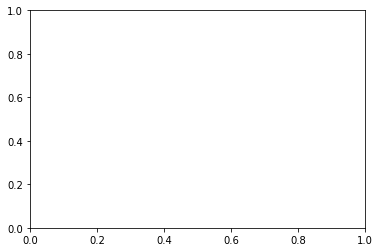

In [149]:
plt.scatter(pred.index, testData["price_diff"], s=1)
plt.plot(pred.index, pred, color="r")
plt.show()
plt.scatter(y, pred)
plt.ylabel("prediction")
plt.xlabel("Actual value")
plt.show()
sns.kdeplot(model.resid)
sm.qqplot(model.resid)
plt.show()

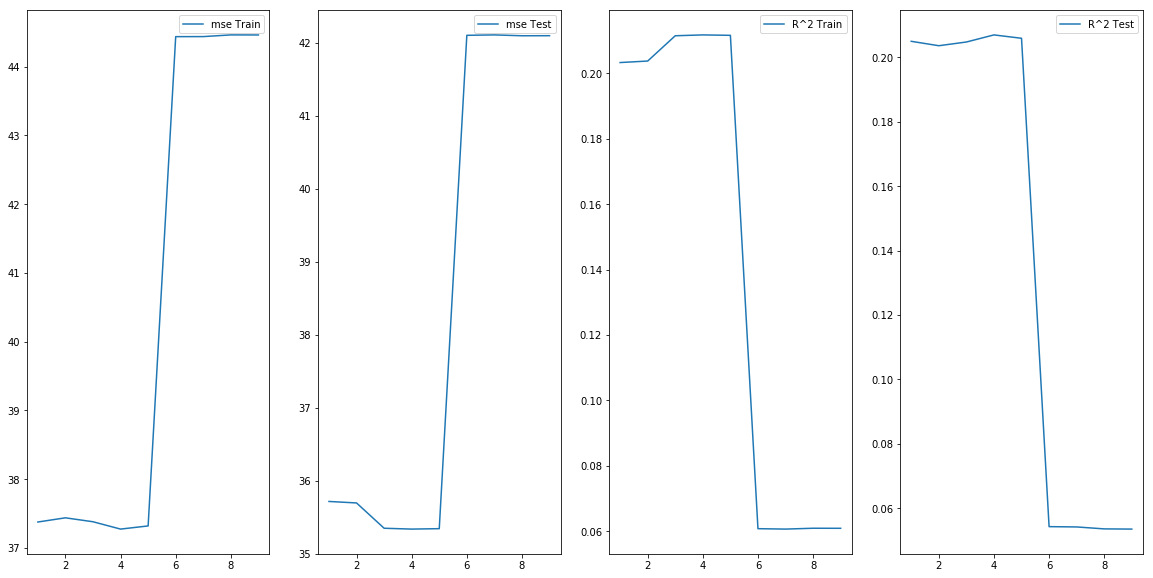

In [124]:
trainData, testData = divideData(data, 0.4)
rSqrTrain = dict()
rSqrTest = dict()
mseTrain = dict()
mseTest = dict()
numberOfRuns = 10
for i in range(1,10):
    rSqrTrainTemp = list()
    rSqrTestTemp = list()
    mseTrainTemp = list()
    mseTestTemp = list()
    for j in range(numberOfRuns):
        formula = getFormulaForDegree(i)
        model = sm.ols(formula, data=trainData).fit()
        rSqrTrainTemp.append(model.rsquared_adj)
        mseTrainTemp.append(model.mse_resid)
        pred = predictWithModel(testData, model)
        mseTestTemp.append(smem.mse(pred,testData["price_diff"]))
        testData["price_diff"].astype('float')
        adjusted_r_squared = calcAdjRsquaredForPrediction(pred, testData["price_diff"], i)
        rSqrTestTemp.append(adjusted_r_squared)
    rSqrTrain[i] = sum(rSqrTrainTemp)/numberOfRuns
    rSqrTest[i] = sum(rSqrTestTemp)/numberOfRuns
    mseTrain[i] = sum(mseTrainTemp)/numberOfRuns
    mseTest[i] = sum(mseTestTemp)/numberOfRuns
fig, ax = plt.subplots(figsize=(20,10), ncols=4)
ax[0].plot(mseTrain.keys(), mseTest.values(), label="mse Train")
ax[1].plot(mseTest.keys(), mseTrain.values(), label="mse Test")
ax[2].plot(rSqrTrain.keys(), rSqrTrain.values(), label="R^2 Train")
ax[3].plot(rSqrTest.keys(), rSqrTest.values(), label="R^2 Test")
for a in ax:
    a.legend()
plt.show()

In [193]:
def getCostsForDayAhead(data):
    return data.day_ahead_price.sum(axis=0)

def getCostsForIntraday(data):
    return data.intraday_price.sum(axis=0)

def getCostsForRandom(data):
    permutation = np.random.permutation(len(data))
    ind = permutation[:int(len(permutation)/2)]
    indIntraday = permutation[int(len(permutation)/2):]
    dayAhead = data.iloc[ind,:]
    intraday = data.iloc[indIntraday,:]
    return (dayAhead.day_ahead_price.sum(axis=0)+intraday.intraday_price.sum(axis=0))

def getCostsForRegression(data, model):
    pred = predictWithModel(data, model)
    pred = pd.DataFrame(pred)
    pred.columns = ["pred_price_diff"]
    pred.index = data.index
    merged = pd.concat([data, pred], axis=1)
    intraday = merged.loc[merged.pred_price_diff<0,:]
    dayAhead = merged.loc[merged.pred_price_diff>=0,:]
    return (dayAhead.day_ahead_price.sum(axis=0)+intraday.intraday_price.sum(axis=0))

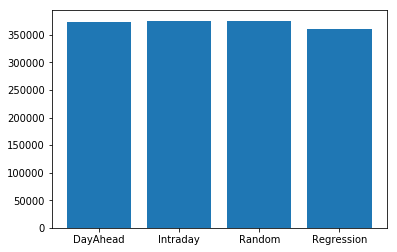

1060.243385027503
6.711351338907338e-62
Ttest_indResult(statistic=42.323977934879615, pvalue=1.3992908795536996e-33)
Ttest_indResult(statistic=49.23887282129223, pvalue=4.923230512788276e-36)
Ttest_indResult(statistic=44.10871419632281, pvalue=3.002818442512891e-34)
Ttest_indResult(statistic=-6.815826017118995, pvalue=4.369766090564224e-08)
Ttest_indResult(statistic=-3.4817502640273315, pvalue=0.0012688362551918503)


In [203]:
from scipy.stats import f_oneway
from scipy import stats

methods = ["DayAhead", "Intraday", "Random", "Regression"]
df = pd.DataFrame(columns=methods)
for n in range(20):
    trainData, testData = divideData(data, 0.4)
    res = []
    for mode in range(1):
        model = trainModel(trainData, mode)
        res.append(getCostsForDayAhead(testData))
        res.append(getCostsForIntraday(testData))
        res.append(getCostsForRandom(testData))
        res.append(getCostsForRegression(testData, model))
    df.loc[n] = res
plt.bar(df.columns.values, res)
plt.show()

stat, p = f_oneway(df["DayAhead"], df["Intraday"], df["Random"], df["Regression"])
print(stat)
print(p)
print(stats.ttest_ind(df["DayAhead"], df["Regression"]))
print(stats.ttest_ind(df["Intraday"], df["Regression"]))
print(stats.ttest_ind(df["Random"], df["Regression"]))
print(stats.ttest_ind(df["DayAhead"], df["Intraday"]))
print(stats.ttest_ind(df["DayAhead"], df["Random"]))